# Phase 3 - Retention Prediction
In the two prevoius phases of this project, I explored the data and prepared it for modeling. In this phase, I create machine learning models to predict retention. I will create Naive Bayes, Decision Tree, and XGBoost models. Evaluation data is used to compare the models' performance.

## Import Required Packages

In [8]:
# Standard Python packages
from math import sqrt
import pickle

# Data packages
import pandas as pd
import numpy as np

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning / Classification packages
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
roc_auc_score, roc_curve, auc,\
confusion_matrix, classification_report,\
ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from xgboost import XGBClassifier
from xgboost import plot_importance


In [65]:
# Load pickled data
with open('Data//prepared data.pickle', 'rb') as file:
    df = pickle.load(file)
df.shape

(413953, 45)

My data is very large, in my first attempt to fit a randomforest model, it was too slow to get any result on my laptop. So I select a subset of the data to train my models.

In [30]:
n = 50000
df1 = df.sample(n, ignore_index=True)
df1.shape

(50000, 45)

## Choose Evaluation Metric
Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, let's examine the class balance of the target variable.

In [32]:
# Get class balance of 'is_retained' col for the entire data
df['is_retained'].value_counts(normalize=True)


is_retained
1.0    0.543663
0.0    0.456337
Name: proportion, dtype: float64

In [33]:
# Get class balance of 'is_retained' col for the subset
df1['is_retained'].value_counts(normalize=True)

is_retained
1.0    0.54288
0.0    0.45712
Name: proportion, dtype: float64

Since our data is well balanced with respect to the `is_retained` column, I use **accuracy** for evaluating the models I will create next.

## Split the Data

In [34]:
y = df1['is_retained']
X = df1.drop(columns=['is_retained'])

# Split into test and 'other'
X_, X_test, y_, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_, y_, stratify=y_, test_size=0.25, random_state=42)
                                                  

## Utility Functions for Reporting Results

In [63]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [64]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

### Build Random forest Model

In [42]:
rf = RandomForestClassifier(random_state=42)

param_grid = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(rf, param_grid, scoring=scoring, cv=4, refit='accuracy')


In [43]:
%%time
rf_cv.fit(X_train, y_train)
print('Done!')


Done!
CPU times: total: 7min 16s
Wall time: 7min 17s


In [44]:
rf_cv.best_score_

np.float64(0.6701666666666666)

In [45]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [46]:
results = pd.DataFrame()
rf_results = make_results('RF cv', rf_cv, 'precision')
results = pd.concat([results, rf_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.686277,0.722891,0.704106,0.670167


## Build XGBoost Model

In [47]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

param_grid = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, param_grid, scoring=scoring, cv=4, refit='precision')

In [48]:
%%time
xgb_cv.fit(X_train, y_train)


CPU times: total: 6min 12s
Wall time: 1min 55s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='precision',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [49]:
# Examine best score
xgb_cv.best_score_

np.float64(0.6961143955581018)

In [50]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.686277,0.722891,0.704106,0.670167
0,XGB cv,0.696023,0.741188,0.717892,0.683767


XGBoost performed better that random forest in all metrics.

## Model Selection

In [51]:
rf_val_preds = rf_cv.best_estimator_.predict(X_val)


In [66]:
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.686277,0.722891,0.704106,0.670167
0,XGB cv,0.696023,0.741188,0.717892,0.683767
0,RF val,0.688802,0.712654,0.700525,0.669200
0,XGB val,0.694859,0.729416,0.711718,0.679200
0,XGB test,0.691918,0.730153,0.710522,0.677000
0,RF val,0.688802,0.712654,0.700525,0.669200


In [67]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.686277,0.722891,0.704106,0.670167
0,XGB cv,0.696023,0.741188,0.717892,0.683767
0,RF val,0.688802,0.712654,0.700525,0.669200
0,XGB val,0.694859,0.729416,0.711718,0.679200
0,XGB test,0.691918,0.730153,0.710522,0.677000
0,RF val,0.688802,0.712654,0.700525,0.669200
0,XGB val,0.694859,0.729416,0.711718,0.679200


## Prediction Using the Champion Model on Test Data

In [68]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.686277,0.722891,0.704106,0.670167
0,XGB cv,0.696023,0.741188,0.717892,0.683767
0,RF val,0.688802,0.712654,0.700525,0.669200
0,XGB val,0.694859,0.729416,0.711718,0.679200
0,XGB test,0.691918,0.730153,0.710522,0.677000
0,RF val,0.688802,0.712654,0.700525,0.669200
0,XGB val,0.694859,0.729416,0.711718,0.679200
0,XGB test,0.691918,0.730153,0.710522,0.677000


## Evaluation of Champion Model

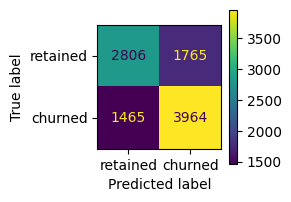

In [69]:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
fig, ax = plt.subplots(figsize=(2,2))
disp.plot(ax=ax);


### Feature Importance

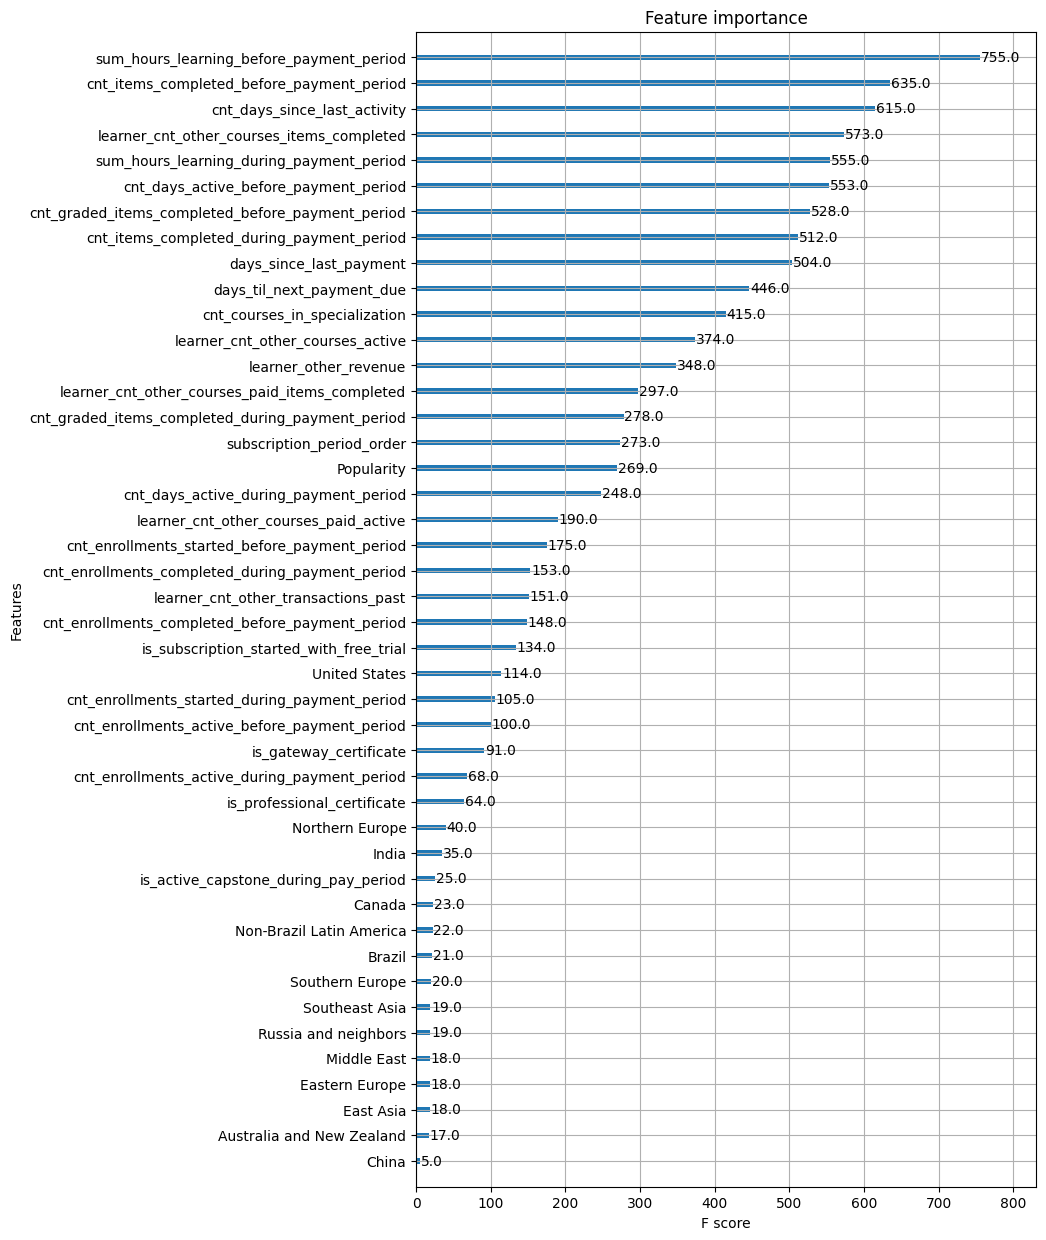

In [62]:
fig, ax = plt.subplots(figsize=(8,15))
plot_importance(xgb_cv.best_estimator_, ax=ax);

## Conclusion
The model's performance is not bad, it gives me a lot of clues for further investigation.
- The feature importance chart says that I can remove the `learner_region` altogether.
- I can define a new feature that represents **engagement**, the more engaged a learner is to their current and previous courses, the higher the chances of retention.
- I can create a measure that represents if the learner is near finishing this specialization and leaving the platform.<br>
This project continues in another phase to improve the model.